In [1]:
import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2 as cv

import synth_text_dataset

from torch.utils.data.dataloader import DataLoader

%matplotlib inline

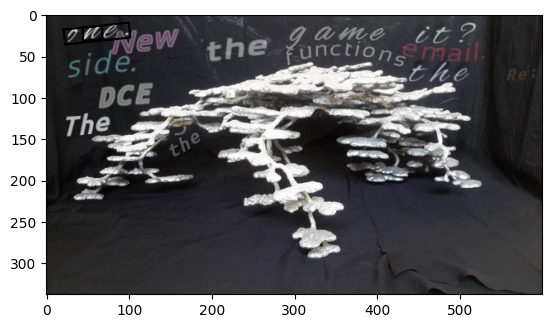

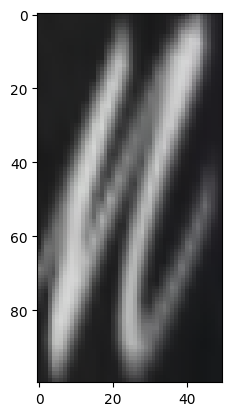

In [2]:
file_name = 'Project/SynthText_train.h5'

db = h5py.File(file_name, 'r')
db_data = db['data']

im_names = list(db_data.keys())

im_name = im_names[2]
img = db_data[im_name][:]
font = db_data[im_name].attrs['font']
txt = db_data[im_name].attrs['txt']
charBB = db_data[im_name].attrs['charBB']
wordBB = db_data[im_name].attrs['wordBB']

# print(f'{font.shape = } {txt.shape = } {charBB.shape = } {wordBB.shape = }')
# print(font[0])
# print(charBB[:,:,0])
# print(np.array(list(charBB[:,i,0] for i in range(charBB.shape[1]))))
char_idx = 1
word_idx = 0
src_points = np.array(list(charBB[:,i,char_idx] for i in range(charBB.shape[1])), dtype=np.float32)

plt.imshow(img)
plt.plot(np.append(charBB[0,:,char_idx], charBB[0,0,char_idx]), np.append(charBB[1,:,char_idx], charBB[1,0,char_idx]), c='black')

plt.plot(np.append(wordBB[0,:,word_idx], wordBB[0,0,word_idx]), np.append(wordBB[1,:,word_idx], wordBB[1,0,word_idx]), c='black')

plt.show()

shape = (50, 100)
dst_points = np.array([[0,0], [shape[0], 0], [shape[0], shape[1]], [0, shape[1]]], dtype=np.float32)


# print(f'{src_points.shape = }\n{dst_points.shape = }')
proj_matrix = cv.getPerspectiveTransform(src_points, dst_points)
out_img = cv.warpPerspective(img, proj_matrix, shape)

# plt.imshow(out_img)
# out_img = out_img.mean(axis=2)
plt.imshow(out_img, cmap='gray')
plt.show()

# plt.imshow(out_img.mean(axis=2), cmap='gray')
# plt.show()

In [3]:
filename = 'Project/SynthText_train.h5'
num_of_images = 998
train_dataset = synth_text_dataset.SynthTextCharactersDataset(filename, end_idx = int(num_of_images * 0.85))
test_dataset = synth_text_dataset.SynthTextCharactersDataset(filename, start_idx = int(num_of_images * 0.85))

# print(dataset[0])
# print(dataset[1])


# print(dataset[0])

# (img_name, charBB), font = dataset[0]
# img_data = dataset.get_image_data(img_name)

# print(img_data.shape)

# plt.imshow(img_data)
# plt.axis('off')

# print(len(dataset))
# for x, y in dataloader:
#     print(len(x[0]))
#     print(len(x[1]))
#     print(len(y))

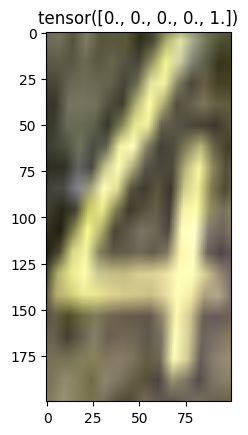

In [4]:
# x, y = dataset[12345]
# print(x, y)

init_shape = (100, 200)

# def char_transform(x):
#     x = dataset.get_char_data(x[0], x[1], init_shape).float()
#     return x.permute((2, 0, 1))

def labels_transform(font):
    label_idx = {b'Titillium Web': 0, b'Alex Brush': 1, b'Ubuntu Mono': 2, b'Open Sans': 3, b'Sansation': 4}[font]
    one_hot_encoded = torch.zeros(5, dtype=torch.float)
    one_hot_encoded[label_idx] = 1
    return one_hot_encoded


# dataset.on_get_item_transform = char_transform
train_dataset.on_get_item_target_transform = labels_transform
test_dataset.on_get_item_target_transform = labels_transform


# char = dataset.get_char_data(x[0], x[1], init_shape)
char, label = train_dataset[123]
# print(char)
plt.imshow(char.int().permute(1, 2, 0))
plt.title(label)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=True)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

from torch import nn
import model

classifier = model.FontClassifierModel(init_shape)
lr = 1e-3
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=lr)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, classifier, loss_fn, optimizer)
    test_loop(test_dataloader, classifier, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.654776  [    0/25970]
loss: 1.647053  [ 6400/25970]
loss: 1.609523  [12800/25970]
loss: 1.618974  [19200/25970]
loss: 1.623050  [25600/25970]
Test Error: 
 Accuracy: 2.7%, Avg loss: 1.606187 

Epoch 2
-------------------------------
loss: 1.603334  [    0/25970]
loss: 1.591346  [ 6400/25970]
loss: 1.604156  [12800/25970]
loss: 1.608268  [19200/25970]
loss: 1.598765  [25600/25970]
Test Error: 
 Accuracy: 14.5%, Avg loss: 1.600925 

Epoch 3
-------------------------------
loss: 1.604595  [    0/25970]
loss: 1.610151  [ 6400/25970]
loss: 1.616411  [12800/25970]
loss: 1.587110  [19200/25970]
loss: 1.601143  [25600/25970]
Test Error: 
 Accuracy: 0.3%, Avg loss: 1.599175 

Epoch 4
-------------------------------
loss: 1.614213  [    0/25970]
loss: 1.620767  [ 6400/25970]
loss: 1.612362  [12800/25970]
loss: 1.606967  [19200/25970]
loss: 1.611937  [25600/25970]
Test Error: 
 Accuracy: 0.1%, Avg loss: 1.598367 

Epoch 5
---------------------------